In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('converted2.csv')

In [3]:
df.head()

,Headline,Journalists,Date,Link,Article
0,"Ivory Coast Keeps Cocoa Export Tax Below 22%, ...",['Baudelaire Mieu'],2011-10-06 15:14:20,http://www.bloomberg.com/news/2011-10-06/ivory...,"Export taxes on cocoa beans from Ivory Coast ,..."
1,USDA Boxed Beef Cutout Closing Prices for Octo...,['Michael Carone'],2011-10-06 20:22:42,http://www.bloomberg.com/news/2011-10-06/usda-...,October 6 (Bloomberg) -- This table details bo...
2,U.S. September Small Business Jobs Summary,['Alex Tanzi'],2011-10-06 19:00:00,http://www.bloomberg.com/news/2011-10-06/u-s-s...,U.S. small business plans to hire declined in ...
3,Greece’s GSEE Says Won’t Meet For Talks With T...,['Natalie Weeks'],2011-10-06 14:45:34,http://www.bloomberg.com/news/2011-10-06/greec...,"Greece ’s biggest private sector union group, ..."
4,Clean-Tech Companies Should Get 10-Year Tax Br...,['Ari Levy'],2011-10-06 18:34:41,http://www.bloomberg.com/news/2011-10-06/clean...,"Reed Hundt, head of the Coalition for Green Ca..."


# Sentimental Analysis

In [4]:
sid = SentimentIntensityAnalyzer()

In [5]:
def get_sentiment(text):
    if isinstance(text, float):
        return sid.polarity_scores('')
    return sid.polarity_scores(text)

In [6]:
df['Scores'] = df['Article'].apply(get_sentiment)

In [7]:
df['Compound'] = df['Scores'].apply(lambda x: x['compound'])

In [8]:
df['Sentiment'] = df['Compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

In [9]:
df.head()

,Headline,Journalists,Date,Link,Article,Scores,Compound,Sentiment
0,"Ivory Coast Keeps Cocoa Export Tax Below 22%, ...",['Baudelaire Mieu'],2011-10-06 15:14:20,http://www.bloomberg.com/news/2011-10-06/ivory...,"Export taxes on cocoa beans from Ivory Coast ,...","{'neg': 0.074, 'neu': 0.882, 'pos': 0.044, 'co...",-0.9327,negative
1,USDA Boxed Beef Cutout Closing Prices for Octo...,['Michael Carone'],2011-10-06 20:22:42,http://www.bloomberg.com/news/2011-10-06/usda-...,October 6 (Bloomberg) -- This table details bo...,"{'neg': 0.021, 'neu': 0.941, 'pos': 0.038, 'co...",0.9300,positive
2,U.S. September Small Business Jobs Summary,['Alex Tanzi'],2011-10-06 19:00:00,http://www.bloomberg.com/news/2011-10-06/u-s-s...,U.S. small business plans to hire declined in ...,"{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp...",0.3182,positive
3,Greece’s GSEE Says Won’t Meet For Talks With T...,['Natalie Weeks'],2011-10-06 14:45:34,http://www.bloomberg.com/news/2011-10-06/greec...,"Greece ’s biggest private sector union group, ...","{'neg': 0.0, 'neu': 0.978, 'pos': 0.022, 'comp...",0.3182,positive
4,Clean-Tech Companies Should Get 10-Year Tax Br...,['Ari Levy'],2011-10-06 18:34:41,http://www.bloomberg.com/news/2011-10-06/clean...,"Reed Hundt, head of the Coalition for Green Ca...","{'neg': 0.028, 'neu': 0.893, 'pos': 0.079, 'co...",0.9698,positive


# Classification Model on the basis of Sentimentals

In [10]:
X = df['Article'].fillna('')
y = df['Sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [13]:
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [14]:
y_pred = model.predict(X_test_vectorized)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7485814690049578
Classification Report:
              precision    recall  f1-score   support

    negative       0.51      0.68      0.58     21102
     neutral       0.82      0.74      0.78      5071
    positive       0.87      0.77      0.82     63180

    accuracy                           0.75     89353
   macro avg       0.73      0.73      0.72     89353
weighted avg       0.78      0.75      0.76     89353



In [16]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative", "neutral"])

In [17]:
cm

array([[48785, 13615,   780],
       [ 6688, 14363,    51],
       [  870,   461,  3740]])

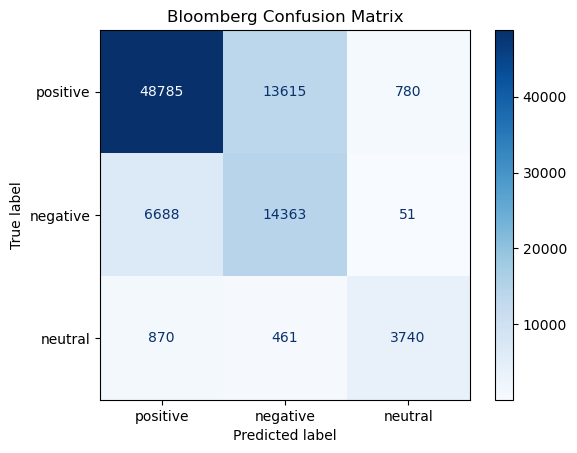

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative", "neutral"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Bloomberg Confusion Matrix")
plt.show()

In [19]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

In [20]:
def predict_sentiment(new_texts):
    new_texts = [preprocess_text(text) for text in new_texts]
    new_texts_tfidf = vectorizer.transform(new_texts)
    predictions = model.predict(new_texts_tfidf)
    return predictions

In [21]:
new_texts = ["Great news for investors! $AAPL, $TSLA, and $AMZN stocks are on the rise, hitting new highs today. Bullish trends continue as market optimism grows. 📈🚀 #StockMarket #Investing #BullMarket"]

In [22]:
predictions = predict_sentiment(new_texts)

In [23]:
print(predictions)

['positive']


# Regression Model on the basis of Score Value

In [24]:
def set_date(date_str):
    date_str_split = date_str.rsplit(' ', 1)
    date_part = date_str_split[0]
    timezone_part = date_str_split[1]
    date_obj = datetime.strptime(date_part, '%Y-%m-%d')
    timezone = pytz.timezone('US/Eastern')
    date_obj = timezone.localize(date_obj)
    formatted_date_time = date_obj.strftime('%Y-%m-%d')
    return formatted_date_time

In [25]:
df['Date'] = df['Date'].apply(set_date)

In [26]:
new_data = pd.DataFrame(df.groupby('Date').agg({'Compound':'mean'}).reset_index())

In [27]:
new_data['Date'] = pd.to_datetime(new_data['Date']).dt.date
new_data.Date=pd.to_datetime( new_data.Date,errors='coerce')

In [28]:
new_data['Months'] = new_data['Date'].dt.month
new_data['Years'] = new_data['Date'].dt.year

In [29]:
new_data

,Date,Compound,Months,Years
0,2006-10-20,-0.585900,10,2006
1,2006-10-21,0.965200,10,2006
2,2006-10-23,-0.211450,10,2006
3,2006-10-24,0.910375,10,2006
4,2006-10-25,0.981600,10,2006
...,...,...,...,...
1910,2013-11-22,0.496953,11,2013
1911,2013-11-23,0.416435,11,2013
1912,2013-11-24,0.377478,11,2013
1913,2013-11-25,0.483877,11,2013


In [30]:
new_data['Date'] = pd.to_datetime(new_data['Years'].astype(str) + '-' + new_data['Months'].astype(str) + '-01', format='%Y-%m-%d')

In [31]:
new_data.drop(['Months', 'Years'], axis=1, inplace=True)

In [32]:
new_data_monthly = pd.DataFrame(new_data.groupby('Date').agg({'Compound':'mean'}).reset_index())

In [33]:
X = new_data_monthly.index.values.reshape(-1, 1)
y = new_data_monthly['Compound'].values.reshape(-1, 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [36]:
y_pred = regressor.predict(X)

# Regression Line for the Monthly data of the BloomBerg News

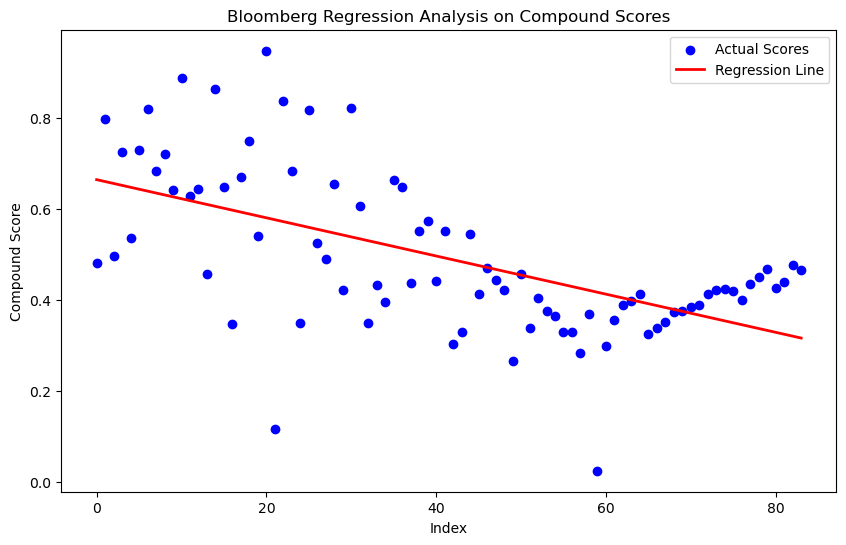

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Scores')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Bloomberg Regression Analysis on Compound Scores')
plt.xlabel('Index')
plt.ylabel('Compound Score')
plt.legend()
plt.show()